In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

# 1. Первичный и визуальный анализ данных

In [2]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)

X.shape, y.shape

((20640, 8), (20640,))

In [3]:
df = pd.concat([X, y], axis=1)

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

В датасете 9 вещественных признаков и 20640 наблюдений. Пропусков нет. Целевой признак – `MedHouseVal`

In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


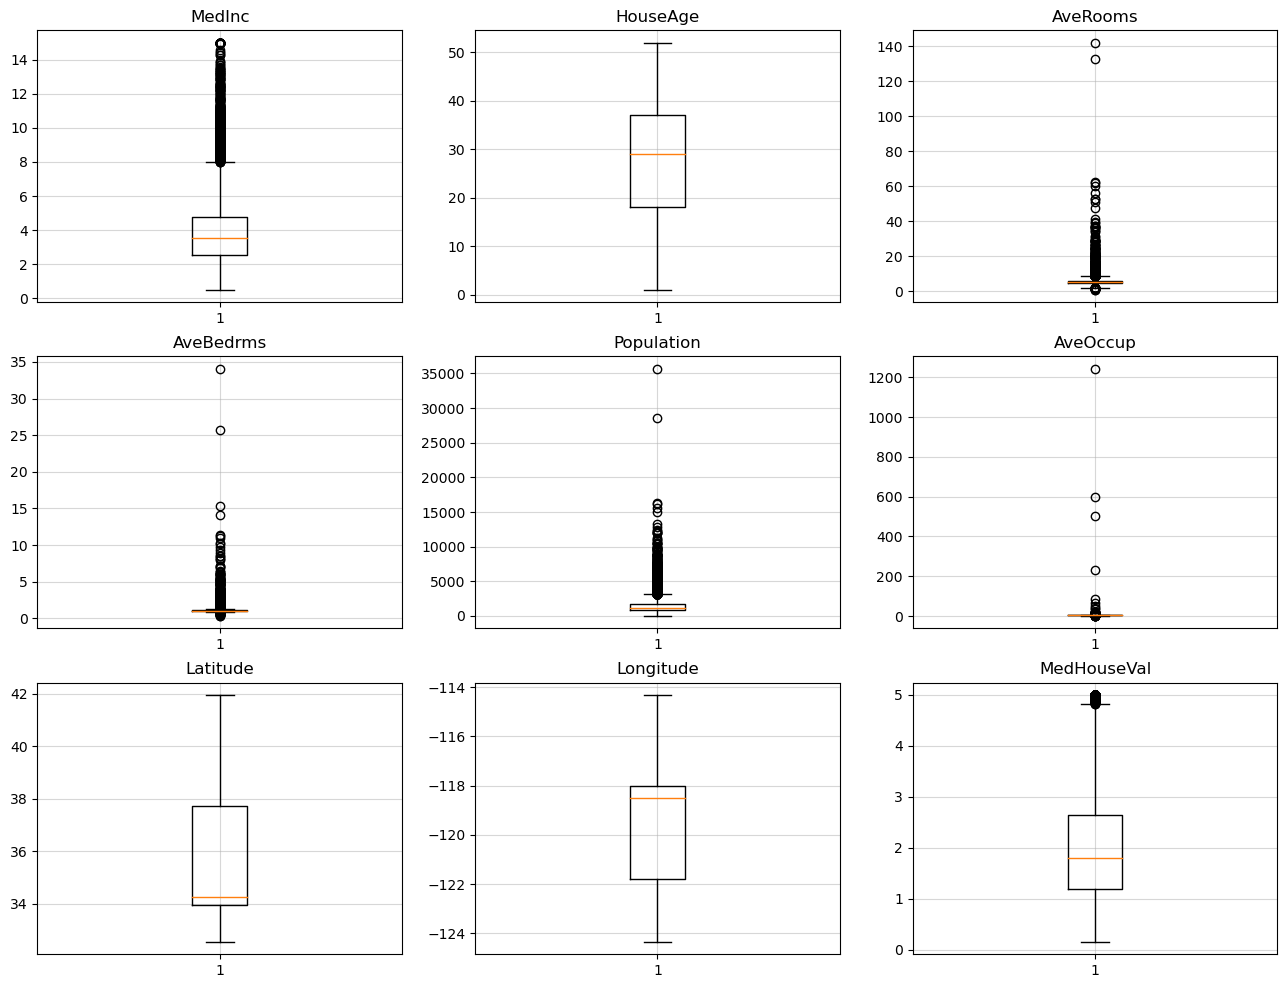

In [8]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(df.columns):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(df[col])
    plt.title(col)
    plt.grid(alpha=.5)

Признаки `MedInc`, `AveRooms`, `AveBedrms`, `Population` и `AveOccup`, а также целевой признак `MedHouseVal` имеют выбросы.

Корреляционная матрица:

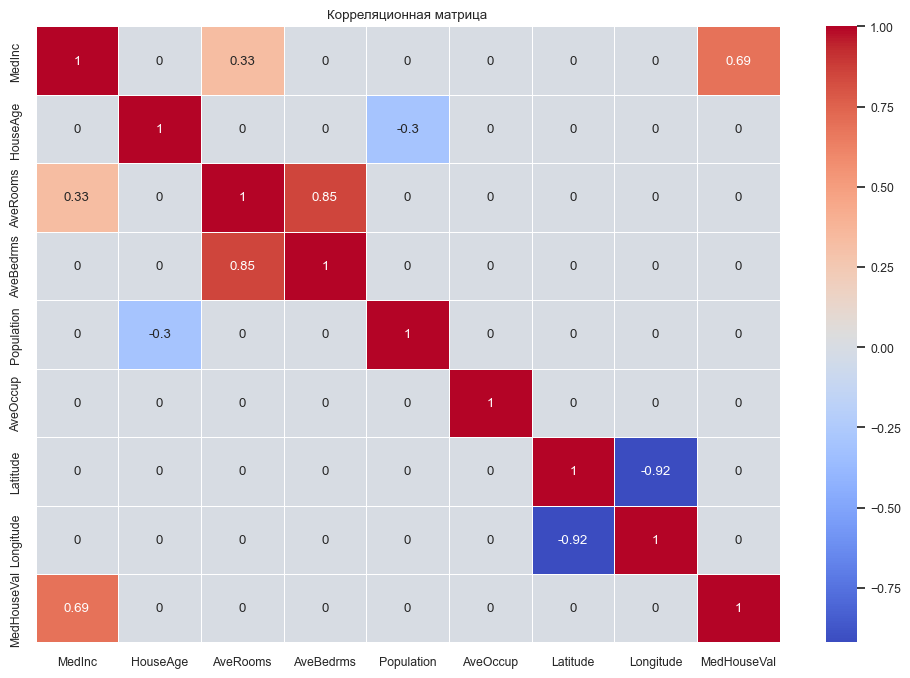

In [9]:
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

plt.figure(figsize=(12, 8))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Корреляционная матрица')
plt.show();

Корреляционная матрица показала, что целевой признак `MedHouseVal` сильно коррелирует с признаком `MedInc`

# 2. Базовое решение

In [201]:
num_epochs = 10
verbose = 0

In [373]:
stata = pd.DataFrame(columns=['Название модели',
                              'Кол-во скрытых слоев',
                              'Кол-во нейронов скрытых слоев',
                              'Ф-я активации',
                              'Оптимизатор',
                              'MSE test',
                              'R2 test'
                              ])
stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test


In [347]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(df.drop('MedHouseVal', axis=1)
                                                    , df['MedHouseVal']
                                                    , test_size=.25
                                                    , random_state=42)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [348]:
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.models import Sequential

In [349]:
tf.random.set_seed(42)

base_model = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(70, activation='relu'),
    Dense(30, activation='relu'),
    Dense(1),
]
)

base_model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 70)                630       
                                                                 
 dense_257 (Dense)           (None, 30)                2130      
                                                                 
 dense_258 (Dense)           (None, 1)                 31        
                                                                 
Total params: 2,791
Trainable params: 2,791
Non-trainable params: 0
_________________________________________________________________


In [359]:
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD

base_model.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse']
                   )

In [360]:
%%time

history = base_model.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 11.4 s, sys: 1.3 s, total: 12.7 s
Wall time: 9.84 s


In [374]:
from sklearn.metrics import r2_score, \
    mean_squared_error as mse, mean_absolute_error as mae

preds = base_model.predict(X_test, verbose=verbose)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

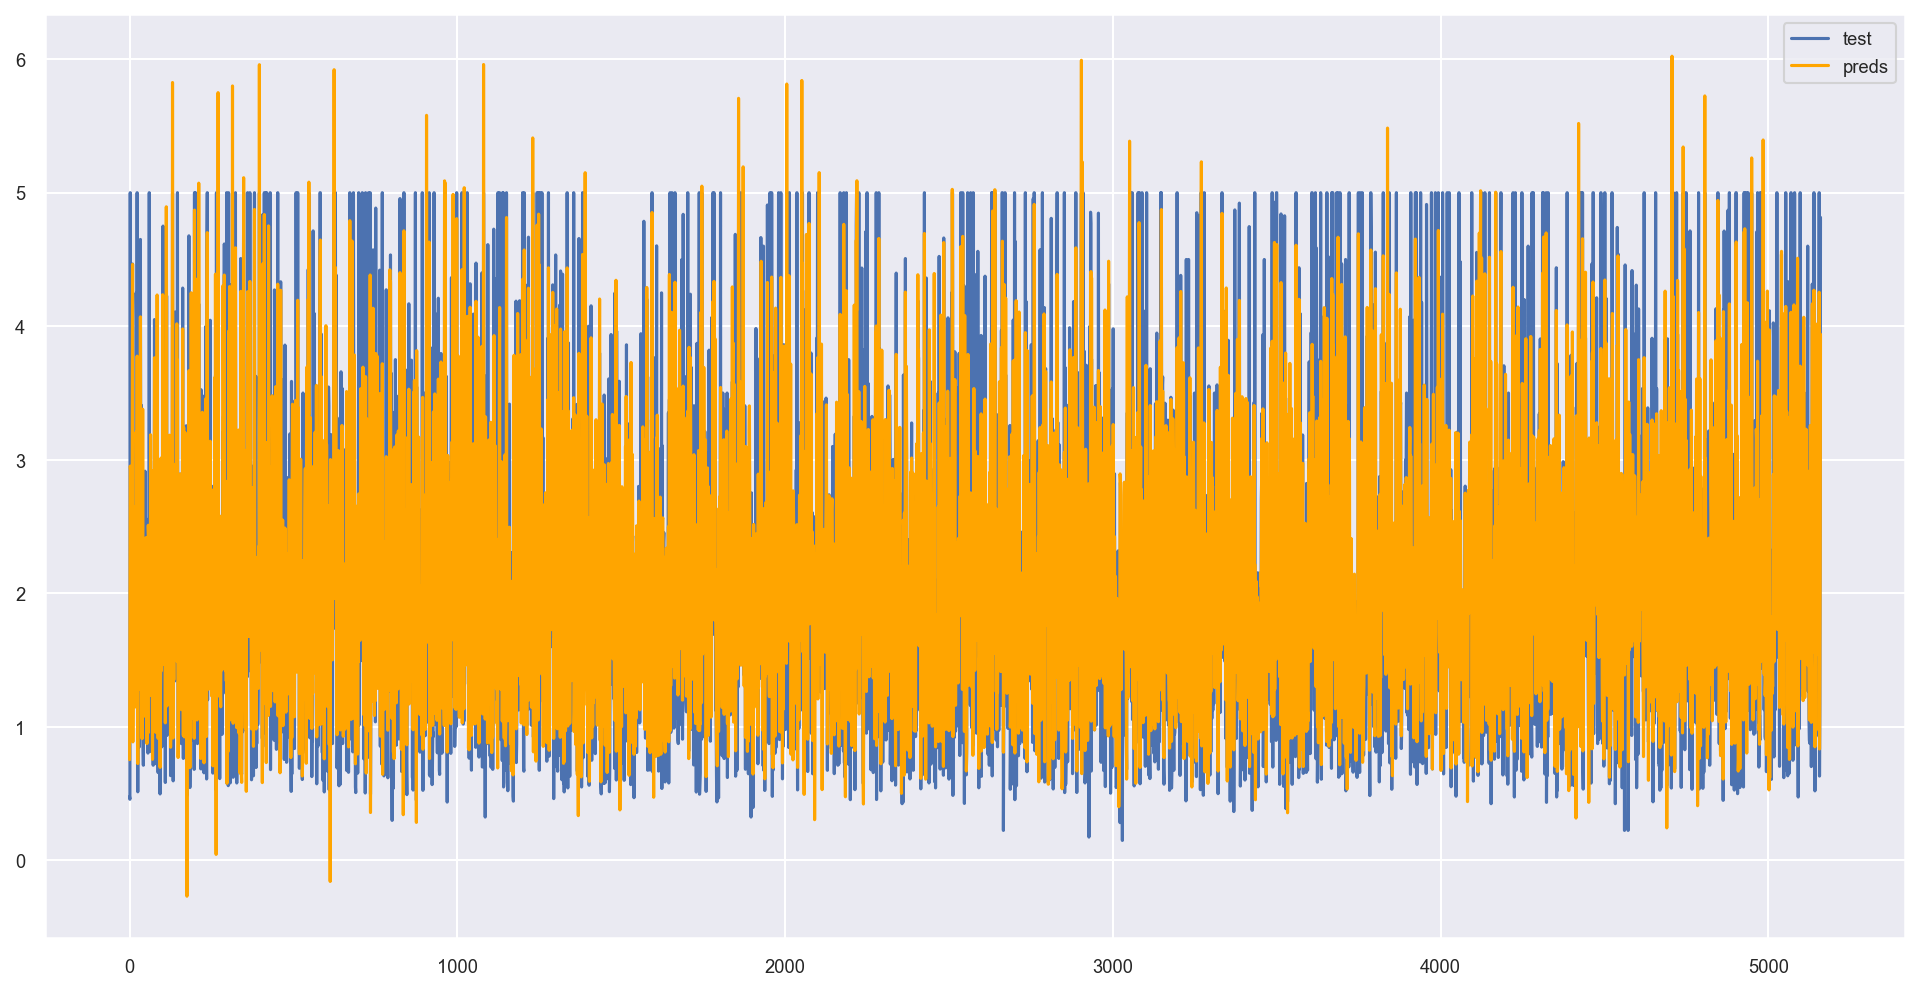

In [365]:
# визуализируем предсказания модели

plt.figure(figsize=(16, 8), dpi=150)

plt.plot(range(len(y_test)), y_test, label="test", c='b')
plt.plot(range(len(preds)), preds, label="preds", c='orange')

plt.legend();

In [375]:
stata = stata.append(
    {
        'Название модели': 'Базовое решение',
        'Кол-во скрытых слоев': 2,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369


# 3. Изменение параметров ИНС

## 3.1 Изменяем число слоев

### 3.1.1 Модель с 4 скрытыми слоями нейронов

In [367]:
tf.random.set_seed(42)

model_1 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(60, activation='relu'),
    Dense(25, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1),
]
)

model_1.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_259 (Dense)           (None, 60)                540       
                                                                 
 dense_260 (Dense)           (None, 25)                1525      
                                                                 
 dense_261 (Dense)           (None, 10)                260       
                                                                 
 dense_262 (Dense)           (None, 5)                 55        
                                                                 
 dense_263 (Dense)           (None, 1)                 6         
                                                                 
Total params: 2,386
Trainable params: 2,386
Non-trainable params: 0
_________________________________________________________________


In [368]:
%%time

model_1.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_1.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 12.2 s, sys: 1.31 s, total: 13.5 s
Wall time: 10.4 s


In [376]:
preds = model_1.predict(X_test, verbose=verbose)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [377]:
stata = stata.append(
    {
        'Название модели': 'Модель №1',
        'Кол-во скрытых слоев': 4,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test,
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759


### 3.1.2 Модель с 8 скрытыми слоями нейронов

In [326]:
tf.random.set_seed(42)

model_2 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(30, activation='relu'),
    Dense(25, activation='relu'),
    Dense(12, activation='relu'),
    Dense(10, activation='relu'),
    Dense(8, activation='relu'),
    Dense(6, activation='relu'),
    Dense(5, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1),
]
)

model_2.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           (None, 30)                270       
                                                                 
 dense_203 (Dense)           (None, 25)                775       
                                                                 
 dense_204 (Dense)           (None, 12)                312       
                                                                 
 dense_205 (Dense)           (None, 10)                130       
                                                                 
 dense_206 (Dense)           (None, 8)                 88        
                                                                 
 dense_207 (Dense)           (None, 6)                 54        
                                                                 
 dense_208 (Dense)           (None, 5)               

Non-trainable params: 0
_________________________________________________________________


In [327]:
%%time

model_2.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_2.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 14.4 s, sys: 1.44 s, total: 15.8 s
Wall time: 15.4 s


In [378]:
preds = model_2.predict(X_test, verbose=verbose)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [379]:
stata = stata.append(
    {
        'Название модели': 'Модель №2',
        'Кол-во скрытых слоев': 8,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test,
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759
2,Модель №2,8,100,relu,SGD,0.484522,0.633830


### 3.1.3 Модель с 12 скрытыми слоями нейронов

In [380]:
tf.random.set_seed(42)

model_3 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(18, activation='relu'),
    Dense(14, activation='relu'),
    Dense(13, activation='relu'),
    Dense(10, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(7, activation='relu'),
    Dense(6, activation='relu'),
    Dense(6, activation='relu'),
    Dense(5, activation='relu'),
    Dense(3, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1),
]
)

model_3.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 dense_264 (Dense)           (None, 18)                162       
                                                                 
 dense_265 (Dense)           (None, 14)                266       
                                                                 
 dense_266 (Dense)           (None, 13)                195       
                                                                 
 dense_267 (Dense)           (None, 10)                140       
                                                                 
 dense_268 (Dense)           (None, 8)                 88        
                                                                 
 dense_269 (Dense)           (None, 8)                 72        
                                                                 
 dense_270 (Dense)           (None, 7)                 63        
                                                                 
 dense_271 (Dense)           (None, 6)                 48        
          

In [381]:
%%time

model_3.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_3.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 14.3 s, sys: 1.48 s, total: 15.8 s
Wall time: 11.6 s


In [382]:
preds = model_3.predict(X_test, verbose=verbose)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [383]:
stata = stata.append(
    {
        'Название модели': 'Модель №3',
        'Кол-во скрытых слоев': 12,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test,
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759
2,Модель №2,8,100,relu,SGD,0.484522,0.633830
3,Модель №3,12,100,relu,SGD,0.476177,0.640137


### 3.1.4 Модель с 15 скрытыми слоями нейронов

In [384]:
tf.random.set_seed(42)

model_4 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(15, activation='relu'),
    Dense(12, activation='relu'),
    Dense(12, activation='relu'),
    Dense(9, activation='relu'),
    Dense(8, activation='relu'),
    Dense(7, activation='relu'),
    Dense(6, activation='relu'),
    Dense(6, activation='relu'),
    Dense(5, activation='relu'),
    Dense(5, activation='relu'),
    Dense(4, activation='relu'),
    Dense(4, activation='relu'),
    Dense(3, activation='relu'),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1),
]
)

model_4.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_277 (Dense)           (None, 15)                135       
                                                                 
 dense_278 (Dense)           (None, 12)                192       
                                                                 
 dense_279 (Dense)           (None, 12)                156       
                                                                 
 dense_280 (Dense)           (None, 9)                 117       
                                                                 
 dense_281 (Dense)           (None, 8)                 80        
                                                                 
 dense_282 (Dense)           (None, 7)                 63        
                                                                 
 dense_283 (Dense)           (None, 6)               

In [385]:
%%time

model_4.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_4.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 17.2 s, sys: 1.66 s, total: 18.9 s
Wall time: 22.3 s


In [386]:
preds = model_4.predict(X_test, verbose=verbose)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [387]:
stata = stata.append(
    {
        'Название модели': 'Модель №4',
        'Кол-во скрытых слоев': 15,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test,
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759
2,Модель №2,8,100,relu,SGD,0.484522,0.633830
3,Модель №3,12,100,relu,SGD,0.476177,0.640137
4,Модель №4,15,100,relu,SGD,1.323242,-0.000018


## 3.2 Изменяем число нейронов

### 3.2.1 Модель с 10 нейронами в скрытых слоях

In [388]:
tf.random.set_seed(42)

model_5 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(6, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1),
]
)

model_5.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_293 (Dense)           (None, 6)                 54        
                                                                 
 dense_294 (Dense)           (None, 4)                 28        
                                                                 
 dense_295 (Dense)           (None, 1)                 5         
                                                                 
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


In [389]:
%%time

model_5.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_5.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 11.2 s, sys: 1.26 s, total: 12.4 s
Wall time: 11.1 s


In [390]:
preds = model_5.predict(X_test, verbose=verbose)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [391]:
stata = stata.append(
    {
        'Название модели': 'Модель №5',
        'Кол-во скрытых слоев': 2,
        'Кол-во нейронов скрытых слоев': 10,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759
2,Модель №2,8,100,relu,SGD,0.484522,0.633830
3,Модель №3,12,100,relu,SGD,0.476177,0.640137
4,Модель №4,15,100,relu,SGD,1.323242,-0.000018
5,Модель №5,2,10,relu,SGD,0.487298,0.631732


### 3.2.2 Модель с 50 нейронами в скрытых слоях

In [392]:
tf.random.set_seed(42)

model_6 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(35, activation='relu'),
    Dense(15, activation='relu'),
    Dense(1),
]
)

model_6.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 35)                315       
                                                                 
 dense_297 (Dense)           (None, 15)                540       
                                                                 
 dense_298 (Dense)           (None, 1)                 16        
                                                                 
Total params: 871
Trainable params: 871
Non-trainable params: 0
_________________________________________________________________


In [393]:
%%time

model_6.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_6.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 11.4 s, sys: 1.31 s, total: 12.7 s
Wall time: 12.4 s


In [394]:
preds = model_6.predict(X_test, verbose=0)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [395]:
stata = stata.append(
    {
        'Название модели': 'Модель №6',
        'Кол-во скрытых слоев': 2,
        'Кол-во нейронов скрытых слоев': 50,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759
2,Модель №2,8,100,relu,SGD,0.484522,0.633830
3,Модель №3,12,100,relu,SGD,0.476177,0.640137
4,Модель №4,15,100,relu,SGD,1.323242,-0.000018
5,Модель №5,2,10,relu,SGD,0.487298,0.631732
6,Модель №6,2,50,relu,SGD,0.486486,0.632346


### 3.2.3 Модель с 120 нейронами в скрытых слоях

In [396]:
tf.random.set_seed(42)

model_7 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(80, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1),
]
)

model_7.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_299 (Dense)           (None, 80)                720       
                                                                 
 dense_300 (Dense)           (None, 40)                3240      
                                                                 
 dense_301 (Dense)           (None, 1)                 41        
                                                                 
Total params: 4,001
Trainable params: 4,001
Non-trainable params: 0
_________________________________________________________________


In [398]:
%%time

model_7.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_7.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 12.7 s, sys: 1.41 s, total: 14.1 s
Wall time: 17.7 s


In [399]:
preds = model_7.predict(X_test, verbose=0)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [400]:
stata = stata.append(
    {
        'Название модели': 'Модель №7',
        'Кол-во скрытых слоев': 2,
        'Кол-во нейронов скрытых слоев': 120,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759
2,Модель №2,8,100,relu,SGD,0.484522,0.633830
3,Модель №3,12,100,relu,SGD,0.476177,0.640137
4,Модель №4,15,100,relu,SGD,1.323242,-0.000018
5,Модель №5,2,10,relu,SGD,0.487298,0.631732
6,Модель №6,2,50,relu,SGD,0.486486,0.632346
7,Модель №7,2,120,relu,SGD,0.464461,0.648991


### 3.2.4 Модель с 150 нейронами в скрытых слоях

In [401]:
tf.random.set_seed(42)

model_8 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(110, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1),
]
)

model_8.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_302 (Dense)           (None, 110)               990       
                                                                 
 dense_303 (Dense)           (None, 40)                4440      
                                                                 
 dense_304 (Dense)           (None, 1)                 41        
                                                                 
Total params: 5,471
Trainable params: 5,471
Non-trainable params: 0
_________________________________________________________________


In [402]:
%%time

model_8.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mse'])

history = model_8.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 13.6 s, sys: 1.59 s, total: 15.2 s
Wall time: 17.2 s


In [403]:
preds = model_8.predict(X_test, verbose=0)
r2_test = r2_score(y_test, preds)
mse_test = mse(y_test, preds)

In [404]:
stata = stata.append(
    {
        'Название модели': 'Модель №8',
        'Кол-во скрытых слоев': 2,
        'Кол-во нейронов скрытых слоев': 150,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'MSE test': mse_test,
        'R2 test': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,MSE test,R2 test
0,Базовое решение,2,100,relu,SGD,0.463961,0.649369
1,Модель №1,4,100,relu,SGD,0.462122,0.650759
2,Модель №2,8,100,relu,SGD,0.484522,0.633830
3,Модель №3,12,100,relu,SGD,0.476177,0.640137
4,Модель №4,15,100,relu,SGD,1.323242,-0.000018
5,Модель №5,2,10,relu,SGD,0.487298,0.631732
6,Модель №6,2,50,relu,SGD,0.486486,0.632346
7,Модель №7,2,120,relu,SGD,0.464461,0.648991
8,Модель №8,2,150,relu,SGD,0.479616,0.637539


## 3.3 Изменяем функции активации